In [1]:
import polars as pl
import pandas as pd
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import os

# Process the Jul 1 to 7 data

In [2]:
filename = rf"..\..\data\concatenated\2024\2024 Taxi and Ride Hailing Records.parquet.gz"

# Read and preprocess the data using polars since the source data is too big
df = pl.read_parquet(filename)
df = df.filter(
    (pl.col('txn_date') >= date(2024, 7, 1)) & (pl.col('txn_date') <= date(2024, 7, 7))
)
df = df.drop(['txn_date', 'txn_hour', 'PUBorough', 'DOLocationID', 'DOBorough','ride_type', 'total_amount'])
#df = df.drop_nulls(subset=['PULocationID'])
df = df.group_by(['timestamp_hour', 'PULocationID']).agg(
    pl.sum('num_txns')
)
df = df.sort("timestamp_hour")
print(df.head())
df.write_csv("heatmap_data.csv")

shape: (5, 3)
┌─────────────────────┬──────────────┬──────────┐
│ timestamp_hour      ┆ PULocationID ┆ num_txns │
│ ---                 ┆ ---          ┆ ---      │
│ datetime[μs]        ┆ i32          ┆ i32      │
╞═════════════════════╪══════════════╪══════════╡
│ 2024-07-01 00:00:00 ┆ 154          ┆ 1        │
│ 2024-07-01 00:00:00 ┆ 10           ┆ 59       │
│ 2024-07-01 00:00:00 ┆ 144          ┆ 125      │
│ 2024-07-01 00:00:00 ┆ 40           ┆ 18       │
│ 2024-07-01 00:00:00 ┆ 7            ┆ 256      │
└─────────────────────┴──────────────┴──────────┘


### Read the CSV file and fill the missing PULocationIDs with zeros

In [3]:
# Read the CSV file
df = pd.read_csv("heatmap_data.csv")

# Convert 'timestamp_hour' to datetime
df["timestamp_hour"] = pd.to_datetime(df["timestamp_hour"], format="%Y-%m-%d %H:%M:%S")

# Get the unique values for PULocationID and timestamp_hour
all_pulocations = df['PULocationID'].unique()
all_timestamps = df['timestamp_hour'].unique()

# Create a DataFrame with all combinations of timestamp_hour and PULocationID
all_combinations = pd.MultiIndex.from_product([all_timestamps, all_pulocations], names=["timestamp_hour", "PULocationID"])
complete_df = pd.DataFrame(index=all_combinations).reset_index()

# Merge this with the original data, filling missing num_txns with 0
df_complete = pd.merge(complete_df, df, on=["timestamp_hour", "PULocationID"], how="left").fillna({'num_txns': 0})

# Display the result
df_complete.head()

,timestamp_hour,PULocationID,num_txns
0,2024-07-01,154.0,1.0
1,2024-07-01,10.0,59.0
2,2024-07-01,144.0,125.0
3,2024-07-01,40.0,18.0
4,2024-07-01,7.0,256.0


In [4]:
# Load shapefile as a GeoDataFrame
shapefile_gdf = gpd.read_file(r"..\data_dictionary\taxi_zones.zip")
shapefile_gdf.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


### Merging

In [5]:
merged_gdf = shapefile_gdf[["LocationID", "geometry"]].merge(df_complete, left_on="LocationID", right_on="PULocationID").drop("LocationID", axis=1)
merged_gdf = merged_gdf.fillna(0)
merged_gdf.head()

,geometry,timestamp_hour,PULocationID,num_txns
0,"POLYGON ((933100.918 192536.086, 933091.011 19...",2024-07-01 00:00:00,1.0,5.0
1,"POLYGON ((933100.918 192536.086, 933091.011 19...",2024-07-01 01:00:00,1.0,1.0
2,"POLYGON ((933100.918 192536.086, 933091.011 19...",2024-07-01 02:00:00,1.0,1.0
3,"POLYGON ((933100.918 192536.086, 933091.011 19...",2024-07-01 03:00:00,1.0,1.0
4,"POLYGON ((933100.918 192536.086, 933091.011 19...",2024-07-01 04:00:00,1.0,0.0


# Geo map

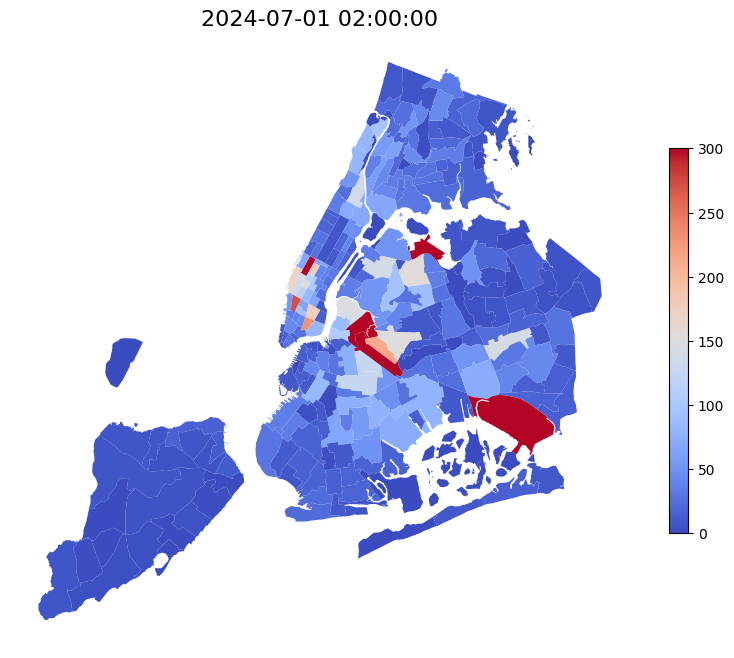

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

specific_hour = "2024-07-01 02:00:00"  # Example timestamp
filtered_gdf = merged_gdf[merged_gdf["timestamp_hour"] == specific_hour] 

# Plot the filtered data
filtered_gdf.plot(
    column="num_txns",
    cmap="coolwarm",
    legend=True,
    legend_kwds={
        'orientation': "vertical",
        'shrink': 0.5  # Adjust the size of the color bar
    },
    vmin=0,  # Set the minimum value for the color scale
    vmax=300,  # Set the maximum value for the color scale
    ax=ax
)

# Customize the map
ax.set_title(f"{specific_hour}", fontsize=16)
ax.axis("off")

plt.show()

### Saving images for multiple timestamps

In [7]:
start_time = pd.to_datetime("2024-07-01 00:00:00")
end_time = pd.to_datetime("2024-07-07 23:00:00")
timestamps = pd.date_range(start_time, end_time, freq="H")

# Create a temporary directory to save individual frames
os.makedirs(r'..\data\images\temp_frames', exist_ok=True)

# Create a list to store the filenames of the frames
filenames = []

for hour in timestamps:
    # Filter the data to a specific timestamp
    filtered_gdf = merged_gdf[merged_gdf["timestamp_hour"] == hour] 
    
    # Make the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Plot the filtered data
    filtered_gdf.plot(
        column="num_txns",
        cmap="coolwarm",
        legend=True,
        legend_kwds={
            'orientation': "vertical",
            'shrink': 0.4  # Adjust the size of the color bar
        },
        vmin=0,  # Set the minimum value for the color scale
        vmax=300,  # Set the maximum value for the color scale
        ax=ax
    )
    
    # Customize the map
    ax.set_title(f"{str(hour)}", fontsize=16)
    ax.axis("off")

    # Save the plot as an image
    frame_filename = rf"..\data\images\temp_frames\{hour.strftime('%Y-%m-%d_%H-%M-%S')}.jpeg"
    plt.savefig(frame_filename, dpi=300, bbox_inches='tight')
    filenames.append(frame_filename)
    plt.close()

# Animating

In [8]:
import imageio

gif_filename = r'..\data\images\transaction_map.gif'
with imageio.get_writer(gif_filename, mode='I', duration=250) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

C:\Users\tonba\AppData\Local\Temp\ipykernel_15876\4007890554.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


### Housekeeping

Delete the temporary images.

In [9]:
# Cleanup temporary frames
for filename in filenames:
    print(filename)
    os.remove(filename)

# Remove temp folder
os.rmdir(r'..\data\images\temp_frames')

# Remove the CSV file
file_path = 'heatmap_data.csv'

# Check if the file exists before attempting to delete it
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} has been deleted.")
else:
    print(f"{file_path} not found.")

..\data\images\temp_frames\2024-07-01_00-00-00.jpeg
..\data\images\temp_frames\2024-07-01_01-00-00.jpeg
..\data\images\temp_frames\2024-07-01_02-00-00.jpeg
..\data\images\temp_frames\2024-07-01_03-00-00.jpeg
..\data\images\temp_frames\2024-07-01_04-00-00.jpeg
..\data\images\temp_frames\2024-07-01_05-00-00.jpeg
..\data\images\temp_frames\2024-07-01_06-00-00.jpeg
..\data\images\temp_frames\2024-07-01_07-00-00.jpeg
..\data\images\temp_frames\2024-07-01_08-00-00.jpeg
..\data\images\temp_frames\2024-07-01_09-00-00.jpeg
..\data\images\temp_frames\2024-07-01_10-00-00.jpeg
..\data\images\temp_frames\2024-07-01_11-00-00.jpeg
..\data\images\temp_frames\2024-07-01_12-00-00.jpeg
..\data\images\temp_frames\2024-07-01_13-00-00.jpeg
..\data\images\temp_frames\2024-07-01_14-00-00.jpeg
..\data\images\temp_frames\2024-07-01_15-00-00.jpeg
..\data\images\temp_frames\2024-07-01_16-00-00.jpeg
..\data\images\temp_frames\2024-07-01_17-00-00.jpeg
..\data\images\temp_frames\2024-07-01_18-00-00.jpeg
..\data\imag